## error_correction package tutorial
Authors: Gloria Ha and Paul Dieterle

Description: With this package we can infer parameters for different models of error generation in spindle assembly.

Last updated: 4/23/2020

In [1]:
# import packages
from error_correction import data_io
from error_correction import generate_data
from error_correction.model import logLikeUnbiasedDelta
from error_correction.inference import emcee_biased_fit
from error_correction.inference import burnInPlotAffine
from error_correction.inference import delete_burn_in
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Generative model derivation

For this tutorial we will focus on the most basic, "independent model."  We can denote $N$ as the number of chromosomes in each cell.  In this model, each chromosome has an equal low probability, $p$, of missegregation in a single division.  In this case, the probability of $M$ missegregations is given by

\begin{equation*}
    P(M) = {N\choose M}p^M(1-p)^{N-M}.
\end{equation*}

The experimental quantity being measured is the number of chromatids in each daughter cell after a single division. In particular, we are looking to calculate the distribution of *differences* in chromatid counts between the two daughter cells. We assume the $M$ chromosomes that missegregate fall into either daughter cell with equal probability. This gives $Q_1$ full chromosomes in daughter cell 1, meaning that daughter cell 1 has a number of chromatids $N_1$ given by

\begin{equation*}
     N_1 = N-M+2Q_1(M),
\end{equation*}

where $Q_1(M)$ is a random variable distributed according to

\begin{equation*}
     P(Q_1) = {M\choose Q_1}2^{-Q_1}2^{-(M-Q_1)} = {M\choose Q_1}2^{-M}.
\end{equation*}

From this, we can deduce that the distribution of $N_1$ is a simple convolution given by

\begin{equation*}
     P(N_1) = \sum_{M=0}^NP(M)P\left(Q_1 = \frac{N_1-N+M}{2}\right) = \sum_{M=0}^N{N\choose M}{M\choose \frac{N_1-N+M}{2}}2^{-M}p^M(1-p)^{N-M},
\end{equation*}

which tells us as well that the distribution of *differences* in chromatid counts,

\begin{equation*}
    P(\Delta = |N_1-N_2| = 2|N_1-N|),
\end{equation*}

is given by

\begin{equation*}
    P(\Delta) = P(N_1 = N-\Delta/2)+p(N_1=N+\Delta/2).
\end{equation*}

As such, we may construct a beautiful likelihood function given $n$ measurements with measurement $j$ showing chromatid difference $\Delta_j$:

\begin{equation*}
    L(p) = \prod_{n=1}^NP(\Delta_j).
\end{equation*}

Below, we give some demonstrations of this likelihood function with two synthetic datasets. In the future, we need to work to characterize our experimental noise. Of course, there is noise inherent to the biological process and measurement noise in counting chromatids.  We have decided on a functional form for the measurement noise -- we will have a probability of false negatives (dots that aren't counted in the image analysis), and each true chromatid has an independent chance of being counted or not counted (binomial).  We have yet to derive the likelihood for this additional layer.

Let us proceed with our demo.

### Generating synthetic data

With the code in our package, we can generate and store synthetic data for the independent and catastrophe models.  Here we will demonstrate how this data can be generated.  We will start by generating data from the independent model for high and low missegregation probability values.

In [2]:
# set up data directory and parameters
data_dir = 'example_data'
p_misseg = [0.003, 0.1]
n_cells = 40
n_chrom = 92
p_left = 0.5
p_fn = 0

# generate and store data
high_ind_data = generate_data.GenerateData('independent',
                                          [p_misseg[1], n_cells, n_chrom, p_left, p_fn],
                                          'high_ind',
                                          data_dir)
low_ind_data = generate_data.GenerateData('independent',
                                          [p_misseg[0], n_cells, n_chrom, p_left, p_fn],
                                          'low_ind',
                                          data_dir)

# display snippet of data
print(high_ind_data.data.head())

# display parameters
print(high_ind_data.params)

   errors  N_1  N_2  dNk  N_1_w_noise  N_2_w_noise  dNk_w_noise
0       9   91   93    2           91           93            2
1      18  100   84   16          100           84           16
2       9   91   93    2           91           93            2
3       9   95   89    6           95           89            6
4       5   91   93    2           91           93            2
{'p_misseg': 0.1, 'n_cells': 40, 'n_chrom': 92, 'p_left': 0.5, 'p_fn': 0}


The `GenerateData` class stores the data in a dataframe and the parameters in a dictionary, as seen above.  The synthetic data includes some information that is hidden in the real data, such as the true number of errors, and the true number of chromatids per cell.

This has also generated two data files per set of parameters, `data_high_ind.txt` and `params_low_ind.yml` in the `example_data` directory, which can then be parsed using the `SyntheticData` class in the `data_io` module.

In [3]:
# let's import the data that we generated
imported_high_ind = data_io.SyntheticData('params_high_ind.yml',
                                          'data_high_ind.txt',
                                          data_dir)
imported_low_ind = data_io.SyntheticData('params_low_ind.yml',
                                         'data_low_ind.txt',
                                         data_dir)
# display snippet of data
print(imported_high_ind.data.head())

# display parameters
print(imported_high_ind.params)
print(imported_low_ind.params)

   errors  N_1  N_2  dNk  N_1_w_noise  N_2_w_noise  dNk_w_noise
0       9   91   93    2           91           93            2
1      18  100   84   16          100           84           16
2       9   91   93    2           91           93            2
3       9   95   89    6           95           89            6
4       5   91   93    2           91           93            2
{'n_cells': 40, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.1}
{'n_cells': 40, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.003}


We can see that the information is recovered when we parse the data files. 

### Parameter estimation

Now we can use our log likelihood function derived above to calculate do parameter estimation on the most likely value of the error rate.

In [4]:
# Next, we determine what range of p we would like to examine
low_range = np.linspace(0.001,0.01,100)
high_range = np.linspace(0.05,0.3,100)

# Then, we calculate our likelihoods
like_high = [logLikeUnbiasedDelta([i], imported_high_ind.data['dNk'],
                                  imported_high_ind.params['n_chrom']) for i in high_range]
like_low = [logLikeUnbiasedDelta([i], imported_low_ind.data['dNk'],
                                  imported_low_ind.params['n_chrom']) for i in low_range]

Let's plot the results.

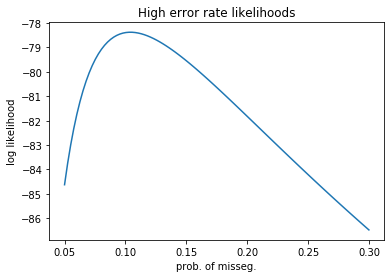

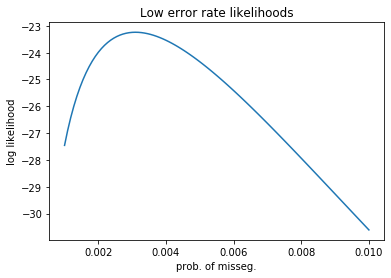

In [5]:
# Then we plot
xl = 'prob. of misseg.'
yl = 'log likelihood'

plt.figure();
plt.plot(high_range,like_high);
plt.xlabel(xl);
plt.ylabel(yl);
plt.title('High error rate likelihoods');

plt.figure();
plt.plot(low_range,like_low);
plt.xlabel(xl);
plt.ylabel(yl);
plt.title('Low error rate likelihoods');

We can report the maximum likelihood estimate for the probability of missegregation.

In [6]:
print('MLE p_misseg for high error rate independent model data: ', high_range[np.argmax(like_high)])
print('MLE p_misseg for low error rate independent model data: ', low_range[np.argmax(like_low)])

MLE p_misseg for high error rate independent model data:  0.10303030303030303
MLE p_misseg for low error rate independent model data:  0.003090909090909091


As we can see, these inferred likelihoods indeed agree quite well with the actual values

In [7]:
print(imported_high_ind.params)
print(imported_low_ind.params)

{'n_cells': 40, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.1}
{'n_cells': 40, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.003}


Of course, one can imagine more complex models. One that we are interested in is the biased, independent missegregation model. In such a scenario, chromosomes that missegregate prefer cell 1 to cell 2, with the probability of ending up in cell 2 being $\alpha<0.5$. In this case, we must adjust the above analysis, which entails a modification of $P(N_1)$ according to:

\begin{equation*}
     P(N_1) = \sum_{M=0}^NP(M)P\left(Q_1 = \frac{N_1-N+M}{2}\right) = \sum_{M=0}^N{N\choose M}{M\choose \frac{N_1-N+M}{2}}\alpha^{(N_1-N+M)/2}(1-\alpha)^{(M-N_1+N)/2}p^M(1-p)^{N-M},
\end{equation*}

Let's see how our inference fares when we increase the complexity of the model.  One parameter that we have not focused on is `p_left`, or the probability that a missegregation ends up in the left cell (directionality is arbitrary here), or that missegregation is directionally biased for some reason.  The underlying biology that could lead to such biased missegregation could be an asymmetric spindle.  We can look at two datasets -- one with perfectly symmetric missegregation (`p_left=0.5`, this dataset was created above) and one with highly asymmetric missegregation (`p_left=0.1`, which we will create now).  We can leave the probability of missegregation fixed at the higher bound 0.1 and use `emcee` to infer the parameters.

In [8]:
# generate and store data
biased_high_ind_data = generate_data.GenerateData('independent',
                                          [p_misseg[1], n_cells, n_chrom, 0.1, p_fn],
                                          'biased_high_ind',
                                          data_dir)

Let's run the inference!  This takes a while to run, so it will print when it's done with 10% of the steps for both the unbiased and the biased data.

In [9]:
pos0 = [0.05, 0.25]
param_names = ['p_misseg', 'p_left']
sampler_unbiased = emcee_biased_fit(imported_high_ind, pos0, nwalkers=50, nsteps=1000)
sampler_biased = emcee_biased_fit(biased_high_ind_data, pos0, nwalkers=50, nsteps=1000)

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


Let's take a look at the MCMC samples.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d94e2d0>,
      dtype=object)

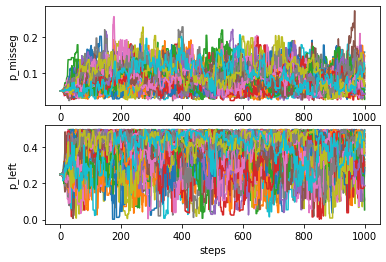

In [10]:
burnInPlotAffine(2, sampler_unbiased, param_names)

We'll cut 400 of those points out before looking at the joint posterior.

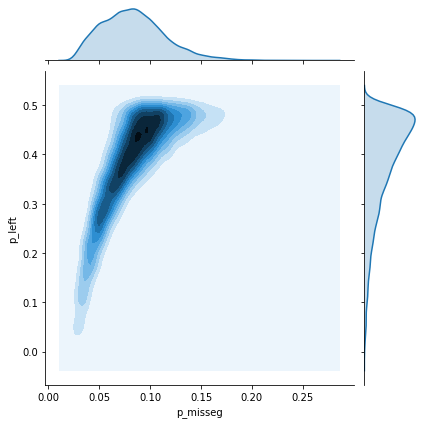

In [11]:
burn_pt = 400
n_dim = 2
samples_unbiased = delete_burn_in(sampler_unbiased, burn_pt, n_dim, param_names)

scatterPlot = sns.jointplot(x='p_misseg', y='p_left', data=samples_unbiased, 
                            kind='kde');

Beautiful. The only problem is that the synthetic data parameters lie at the edge of parameter space, so MCMC seems to not have enough density around p_left = 0.5

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ebece90>,
      dtype=object)

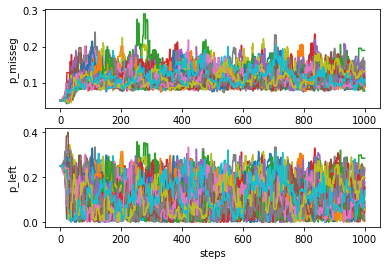

In [12]:
burnInPlotAffine(2, sampler_biased, param_names)

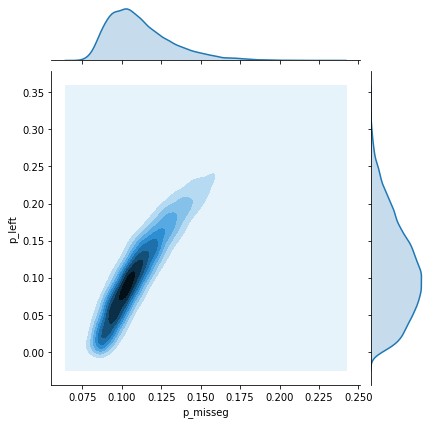

In [13]:
samples_biased = delete_burn_in(sampler_biased, burn_pt, n_dim, param_names)

scatterPlot = sns.jointplot(x='p_misseg', y='p_left', data=samples_biased, 
                            kind='kde');

Another really beautiful plot that recapitulates our simulation parameters, as shown when one looks at the MAP values

In [14]:
print(samples_unbiased.quantile([0.50], axis=0))
print(samples_biased.quantile([0.50], axis=0))

     p_misseg   p_left
0.5   0.08138  0.40704
     p_misseg    p_left
0.5  0.107538  0.104356


and compares to the actual parameters

In [15]:
print(imported_high_ind.params)
print(biased_high_ind_data.params)

{'n_cells': 40, 'n_chrom': 92, 'p_fn': 0, 'p_left': 0.5, 'p_misseg': 0.1}
{'p_misseg': 0.1, 'n_cells': 40, 'n_chrom': 92, 'p_left': 0.1, 'p_fn': 0}


Another issue we must confront is the possibility of miscounting the number of kinetochores in daughter cells. Let's try to understand how this could happen. To do so, we will need to go beyond looking solely at the difference in kinetochore counts between the daughter cells and must instead look at the values in each cell.

Assume we have cells with $N$ chromosomes; after division, we observe $N_1$ kinetochores in daughter cell 1 and $N_2$ kinetochores in daughter cell 2. If $N_1+N_2<2N$,we know we have "lost" some of the chromosomes.

If the probability a chromosome is detected is $p_d$, then we can calculate the joint distribution $p(N_1, N_2)$ according to the following:

(1) Assume that $\tilde{N}_1$ chromatids are actually in daughter cell 1; this means that $2N-\tilde{N}_1$ are in daughter cell 2. The probability of this happening is model-dependent. We will call it $P(\tilde{N}_1)$, acknowledging that one must choose a model -- unbiased, biased, catastrophe, etc. -- to calculate this quantity;

(2) Given that $\tilde{N}_1$ chromatids end up in daughter cell 1, the probability of detecting $N_1$ of them is ${\tilde{N}_1\choose N_1}p_d^{N_1}(1-p_d)^{\tilde{N}_1-N_1}$;

(3) Given that $2N-\tilde{N}_1$ chromatids are in daughter cell 2, the probability of detecting $N_2$ of them is ${2N-\tilde{N}_1\choose N_2}p_d^{N_2}(1-p_d)^{2N-\tilde{N}_1-N_2}$;

and

(4) Given (1)-(3), the joint probability $p(N_1, N_2)$ is given by

$$p(N_1, N_2) = \sum_{\tilde{N}_1=N_1}^{2N-N_2}P(\tilde{N}_1){\tilde{N}_1\choose N_1}{2N-\tilde{N}_1\choose N_2}p_d^{N_1+N_2}(1-p_d)^{2N-N_1-N_2}$$

We will have to modify our data structures to work with this object, but plan to do so this week now that we have corrected our inference issues from last week.